In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from scipy.special import expit, logit
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-05-16 08:21:28.197912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
train['BZ_GSM'] = train['BZ_GSM'].fillna(train['BZ_GSM'].mean())  # Naplní NaN hodnoty priemerom danej stĺpca
test['BZ_GSM'] = test['BZ_GSM'].fillna(test['BZ_GSM'].mean())   
features = ['time1', 'DST', 'DST+1', 'BZ_GSM']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicators = ["DST", "BZ_GSM"]
y_col='DST+1'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

In [6]:
n_input = 6  
n_features= len(X_train) 
b_size = 256  

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)


In [7]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  896
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [8]:
inputs = Input(shape=(6,2))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 2)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           134144    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [9]:
saved_model = "1h_dopredu200+BZ.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=200, verbose=1, callbacks = callbacks_list)

Epoch 1/200
1139/1139 [==============================] - ETA: 0s - loss: 114.4281 - mae: 4.9304
Epoch 1: val_mae improved from inf to 3.54899, saving model to 1h_dopredu200+BZ.hdf5
1139/1139 [==============================] - 74s 61ms/step - loss: 114.4281 - mae: 4.9304 - val_loss: 60.4488 - val_mae: 3.5490
Epoch 2/200
1139/1139 [==============================] - ETA: 0s - loss: 39.6650 - mae: 3.4709
Epoch 2: val_mae did not improve from 3.54899
1139/1139 [==============================] - 66s 58ms/step - loss: 39.6650 - mae: 3.4709 - val_loss: 43.3314 - val_mae: 3.7452
Epoch 3/200
1139/1139 [==============================] - ETA: 0s - loss: 33.3695 - mae: 3.3455
Epoch 3: val_mae improved from 3.54899 to 3.04197, saving model to 1h_dopredu200+BZ.hdf5
1139/1139 [==============================] - 70s 61ms/step - loss: 33.3695 - mae: 3.3455 - val_loss: 33.9769 - val_mae: 3.0420
Epoch 4/200
1139/1139 [==============================] - ETA: 0s - loss: 28.1439 - mae: 3.1350
Epoch 4: val_mae 

In [10]:
model = keras.models.load_model('1h_dopredu200+BZ.hdf5')

In [11]:
y_pred = model.predict(test_generator)

633/633 [==============================] - 13s 18ms/step


In [12]:
y_val_pred = model.predict(val_generator)

true_labels_val = np.where(y_val[n_input:] <= -20, 1, 0) 

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

thresholds = np.arange(-10, -40, -0.1)
mcc_scores = []

for thresh in thresholds:
    predictions = np.where(y_val_pred <= thresh, 1, 0)
    mcc = calculate_mcc(true_labels_val, predictions)
    mcc_scores.append(mcc)

best_threshold_mcc = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print("Best Threshold for MCC on Validation Set:", best_threshold_mcc)
print("Best MCC on Validation Set:", best_mcc)
best_threshold_mcc_rounded = round(best_threshold_mcc, 1)

224/224 [==============================] - 4s 18ms/step
Best Threshold for MCC on Validation Set: -18.89999999999997
Best MCC on Validation Set: 0.9050334083955451
-18.9


In [13]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test[:-6], y_pred.reshape(-1))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 99.42540910179977


In [14]:
y_pred2 = np.where(y_pred <= best_threshold_mcc_rounded, 1, 0)
# [n_input:] because prediction starts from n-th row
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[127292   2693]
 [  2760  29285]]


In [15]:
print(classification_report(y_test2, y_pred2))


              precision    recall  f1-score   support

           0       0.98      0.98      0.98    129985
           1       0.92      0.91      0.91     32045

    accuracy                           0.97    162030
   macro avg       0.95      0.95      0.95    162030
weighted avg       0.97      0.97      0.97    162030



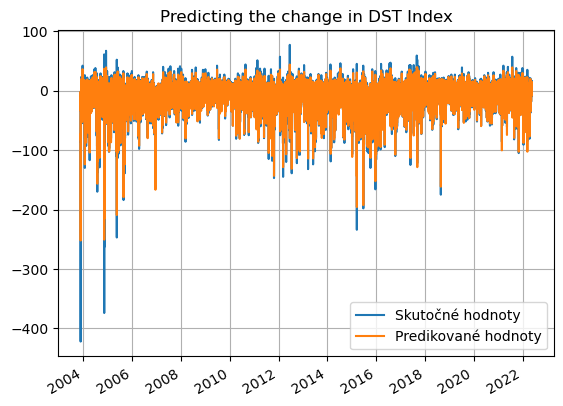

In [16]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [17]:
df.to_csv('1h_dopredu+200+BZ.csv')

In [18]:
TN, FP, FN, TP = cm.ravel()
ACC = (TP + TN) / (TP + TN + FP + FN)
MCC = matthews_corrcoef(y_test2, y_pred2)
print("ACC={}".format(ACC))
print("MCC={}".format(MCC))

ACC=0.9663457384434981
MCC=0.8938581799207543
